<a href="https://colab.research.google.com/github/hugegene/LSTM-Prediction-of-Stock-Price-Movement/blob/master/SentimentTestingUSDLoop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rolling LSTM testing on USD price movements

## 1 Objective and Overview

A supervised learning was done to make trading decisions (Sell or Buy) for USD using USD's past price and MarketRisk TRMI.

The supervised model used was LSTM.  



## 1.1 Splitting Train-Validate-Test Set

2016-11-01 data to 2017-12-31 USD price and TRMI MarketRisk data was used for this experiment.

The data is plit to rolling train and test sets as shown:


The effective test period is from 2017-01-01 to 2017-12-31

The graph below shows the USD price over the effective test period.


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


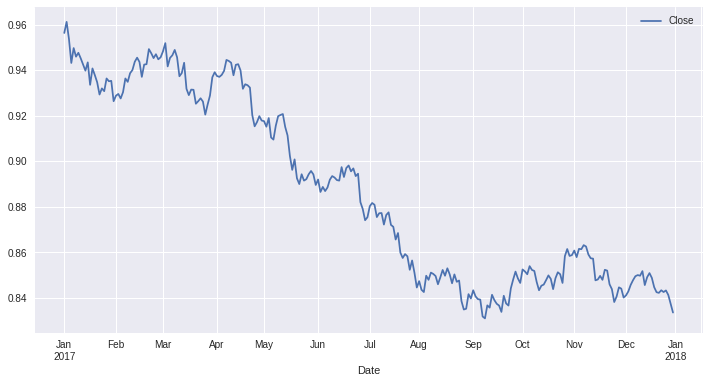

In [31]:
# Plotting USD prices
ax = tradeTable["2017-01-01":"2017-12-31"].plot(y=['Close'], figsize=(12,6), grid=True)

## 1.2 Feature Engineering

![alt text](https://github.com/hugegene/LSTM-Prediction-of-Stock-Price-Movement/blob/master/USDprice.png?raw=1)

USD price was overlayed with various TRMIs moving averages and the 30-days MarketRisk moving average seems to co-related well with the price visually. As such, the following was feature-enginnered as the input to the LSTM model for all the experiments:

1. 90-day MarketRisk moving-average
2. 30-day MarketRisk moving-average
3. Close
4. 100-day Close moving-average

## 1.3 Evaluation Metrics

The evaluation metrics are:
1. Matthews correlation coefficient (MCC)
2. Accuracy
3. Profit and Loss


## 1.4 Labels

Each timestep is labelled Sell(0) or Buy(1) depending on whether the next closing price is up or down.


## 1.5 LSTM Set-Up

The LSTM is set-up to predict the labels based on the sequential data of the past 5 time-steps.


## 1.6 Trading

Each LSTM prediction of Buy will result in a buying and holding of USD for 1 day  and each LSTM prediction of Sell will result in a short-sell and holding of USD for 1 day.

## 2 Results 

Confusion matrix, without normalization
[[12  8]
 [10 12]]


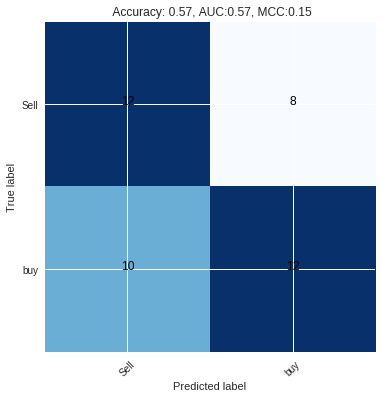

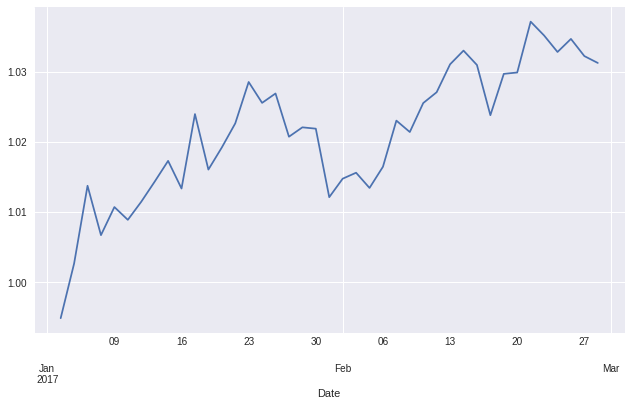

In [26]:
# calculating cumulative predicted and labelled trade returns over each time step
PNLTable =  tradeTable.loc["2017-01-01":"2017-02-28",:].copy()
PNLTable["labelledPNL"] =  (1+PNLTable['labelledreturns']).cumprod()
PNLTable["PNL"] = (1+PNLTable['predictedreturns']).cumprod()
PNLTable.head()

#plotting Confusion Matrix
f = plt.figure(figsize=(15,7))
ax = f.add_subplot(131)
plotConfusion("2017-01-01", "2017-02-28", "")

f = plt.figure(figsize=(36,6))
ax = f.add_subplot(131)

# PNL Plot for the Test Period
PNLTable["PNL"].plot()

## 2.1 Evaluation

**Good**

In the experiment, 8 LSTM models were trained to predict 1 week of USD price movement ahead. The LSTM model fitted the train set as much as it could and was used to predict the next week's USD price movements. 

The above confusion matrix shows a good spread of predicted Buy and Sell decisions with a accuracy of 0.57 and MCC of 0.15.

The above PNL plot also shows that the 8 LSTM trained at one go, without any cherry picking of LSTM models, gives rise to 3% profit in 2 months.

**Bad**

However, more testing is required to prove that the above methodology is not one-off event. 
More testings with longer rolling periods of test sets are required. 
Repeated testing of the same period of test sets are required to ensure that the repeated test will produce the same results.


##  3 Codes

In [7]:
from google.colab import files
uploaded = files.upload()

Saving USDSentiment.csv to USDSentiment.csv


In [12]:
!ls

best.h5  sample_data  us500Prices.csv  USDprices.csv  USDSentiment.csv


In [2]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot as plt
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Activation, LSTM
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.models import model_from_json
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from datetime import datetime
import os
import itertools
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from keras.layers import Input, LSTM, RepeatVector, Lambda, Dense, Flatten, Permute, merge, multiply
from keras.models import Model
from keras import backend as K
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import roc_auc_score as areauc
import tensorflow as tf
from datetime import timedelta, date

Using TensorFlow backend.


## 3.1 Data Preparation

In [3]:
##Read in Price data, use date as index
Prices = pd.read_csv("USDprices.csv")
Prices.head()
Prices['Date'].dtype
Prices['Date'] = pd.to_datetime(Prices['Date'], format='%Y-%m-%d')
Prices.head()
Prices.index = Prices['Date']
# print(Prices.head())

#Reading in Sentiment Data and selecting News-only-MarketRisk Sentiment
Sent = pd.read_csv("USDSentiment.csv")
Sent = Sent[Sent.dataType=='News'][['Date', 'marketRisk']].fillna(method = "ffill")
# Sent.head()
Sent['Date'] = pd.to_datetime(Sent['Date'], format='%Y-%m-%d')
Sent.index = Sent['Date']
# print(Sent.head())

#Combining Price table and Sentiment Table
Ana = Prices.merge(Sent, left_index= True, right_index=True, how='inner')
Ana.head()
Ana.columns
Ana = Ana.drop(columns=['Unnamed: 0', 'Volume', 'Asset', 'Date_x', 'Date_y', 'Open', 'High', 'Low', 'UnadjClose'])
Ana.head()

# calculating r, %tage change of closing price over previous time step
Ana['returns'] = (Ana['Close']- Ana['Close'].shift(1))/Ana['Close'].shift(1)
Ana.head()

# calculating target price
Ana['Target'] = Ana["Close"].diff(1).shift(-1)
Ana.head()

# calculating %change
Ana['Change'] = Ana["returns"].shift(-1)
Ana.head()


## Label each time step False(no-buy) or True(buy) based on whether the price will rise at the next closing price
timestep = 1
labels = []
for i in range(0, Ana.shape[0]):
  if(i+timestep< Ana.shape[0]):
    aheadGain = [Ana["returns"][i+j] for j in range(1,timestep+1)]
    labels+= [np.sum(aheadGain)> 0]

print(len(labels))

# Price Table with Labels as Signal
Ana = Ana.iloc[:-timestep,:].copy()
Ana.head()
Ana['Signal'] = labels
Ana.head()

#Feature Engineering
Ana["Close30"] =  Ana["Close"].rolling(30).mean()
Ana["Close100"] =  Ana["Close"].rolling(100).mean()
Ana["r1"] =  Ana["Close"].diff(1)
Ana["r2"] =  Ana["Close"].diff(7)
Ana["marketrisk_avg30"] = Ana["marketRisk"].rolling(30).mean()
Ana["marketrisk_avg90"] = Ana["marketRisk"].rolling(90).mean()

#Drop NA
Ana = Ana.dropna(0)
Ana.head()

5448


,Close,marketRisk,returns,Target,Change,Signal,Close30,Close100,r1,r2,marketrisk_avg30,marketrisk_avg90
Date,,,,,,,,,,,,
1998-05-21,0.894694,0.017921,-0.005816,-0.001439,-0.001608,False,0.905687,0.916241,-0.005234,-0.007833,0.030184,0.034995
1998-05-22,0.893256,0.054887,-0.001608,0.004813,0.005388,True,0.904816,0.916045,-0.001439,-0.011721,0.030500,0.035283
1998-05-25,0.898069,0.072076,0.005388,0.001373,0.001529,True,0.904089,0.915792,0.004813,-0.005518,0.031202,0.035543
1998-05-26,0.899442,0.120229,0.001529,0.006027,0.006700,True,0.903746,0.915530,0.001373,-0.007587,0.034618,0.036311
1998-05-27,0.905469,0.057863,0.006700,-0.001718,-0.001898,False,0.903617,0.915352,0.006027,-0.001643,0.036330,0.036533


In [4]:
#Define function to convert dataframe to training, validating and testing examples
def series_to_supervised(df, n_in=1, n_out=1):
	n_vars = 1 if type(df) is list else df.shape[1]
  
  
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, -1, -1):
		cols.append(df.shift(i))
		names += [(df.columns[j]+'(t-%d)' % (i)) for j in range(n_vars)]

	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	return agg

#Features Selection
Set =  Ana[['Close', 'Close100', 'marketrisk_avg90', 'marketrisk_avg30']]
# Set =  Ana[['r1', 'r2']]
FEATURES_SHAPE =  Set.shape[1]
print(FEATURES_SHAPE)

#Forming examples
SEQ_LEN = 5
Set =  series_to_supervised(Set, SEQ_LEN-1, 0)
Set[["Change", "Signal"]] = Ana[["Change", "Signal"]]
Set = Set.dropna()
print(Set.shape)
Set.head()

4
(5345, 22)


,Close(t-4),Close100(t-4),marketrisk_avg90(t-4),marketrisk_avg30(t-4),Close(t-3),Close100(t-3),marketrisk_avg90(t-3),marketrisk_avg30(t-3),Close(t-2),Close100(t-2),...,Close(t-1),Close100(t-1),marketrisk_avg90(t-1),marketrisk_avg30(t-1),Close(t-0),Close100(t-0),marketrisk_avg90(t-0),marketrisk_avg30(t-0),Change,Signal
Date,,,,,,,,,,,,,,,,,,,,,
1998-05-27,0.894694,0.916241,0.034995,0.030184,0.893256,0.916045,0.035283,0.030500,0.898069,0.915792,...,0.899442,0.915530,0.036311,0.034618,0.905469,0.915352,0.036533,0.036330,-0.001898,False
1998-05-28,0.893256,0.916045,0.035283,0.030500,0.898069,0.915792,0.035543,0.031202,0.899442,0.915530,...,0.905469,0.915352,0.036533,0.036330,0.903751,0.915163,0.036895,0.035828,0.003719,True
1998-05-29,0.898069,0.915792,0.035543,0.031202,0.899442,0.915530,0.036311,0.034618,0.905469,0.915352,...,0.903751,0.915163,0.036895,0.035828,0.907112,0.915000,0.037338,0.036237,-0.004515,False
1998-06-01,0.899442,0.915530,0.036311,0.034618,0.905469,0.915352,0.036533,0.036330,0.903751,0.915163,...,0.907112,0.915000,0.037338,0.036237,0.903016,0.914801,0.037892,0.038099,0.000813,True
1998-06-02,0.905469,0.915352,0.036533,0.036330,0.903751,0.915163,0.036895,0.035828,0.907112,0.915000,...,0.903016,0.914801,0.037892,0.038099,0.903751,0.914626,0.038163,0.038561,-0.005840,False


In [5]:
#Remove bad training and validating examples
SetAdjusted = Set.copy()
# SetAdjusted = Set.loc[(Set.Change< -0.0015)| (Set.Change> 0.003)]
SetAdjusted.head()

,Close(t-4),Close100(t-4),marketrisk_avg90(t-4),marketrisk_avg30(t-4),Close(t-3),Close100(t-3),marketrisk_avg90(t-3),marketrisk_avg30(t-3),Close(t-2),Close100(t-2),...,Close(t-1),Close100(t-1),marketrisk_avg90(t-1),marketrisk_avg30(t-1),Close(t-0),Close100(t-0),marketrisk_avg90(t-0),marketrisk_avg30(t-0),Change,Signal
Date,,,,,,,,,,,,,,,,,,,,,
1998-05-27,0.894694,0.916241,0.034995,0.030184,0.893256,0.916045,0.035283,0.030500,0.898069,0.915792,...,0.899442,0.915530,0.036311,0.034618,0.905469,0.915352,0.036533,0.036330,-0.001898,False
1998-05-28,0.893256,0.916045,0.035283,0.030500,0.898069,0.915792,0.035543,0.031202,0.899442,0.915530,...,0.905469,0.915352,0.036533,0.036330,0.903751,0.915163,0.036895,0.035828,0.003719,True
1998-05-29,0.898069,0.915792,0.035543,0.031202,0.899442,0.915530,0.036311,0.034618,0.905469,0.915352,...,0.903751,0.915163,0.036895,0.035828,0.907112,0.915000,0.037338,0.036237,-0.004515,False
1998-06-01,0.899442,0.915530,0.036311,0.034618,0.905469,0.915352,0.036533,0.036330,0.903751,0.915163,...,0.907112,0.915000,0.037338,0.036237,0.903016,0.914801,0.037892,0.038099,0.000813,True
1998-06-02,0.905469,0.915352,0.036533,0.036330,0.903751,0.915163,0.036895,0.035828,0.907112,0.915000,...,0.903016,0.914801,0.037892,0.038099,0.903751,0.914626,0.038163,0.038561,-0.005840,False


## 3.2 Train-Validate-Test Split

In [29]:
daterange = pd.date_range(start='1/1/2017', periods=13, freq='1W')
print(daterange)
tradeTable= Ana.loc["2017-01-01":"2018-01-01",:].copy()
tradeTable["predictSignal"] = 0
# tradeTable.head()

for single_date in daterange:
  TRAIN_START = (single_date - timedelta(days=90)).strftime("%Y-%m-%d")
  TRAIN_END = (single_date - timedelta(days=1)).strftime("%Y-%m-%d") 
  TEST_START = (single_date).strftime("%Y-%m-%d")
  TEST_END = (single_date + timedelta(days=6)).strftime("%Y-%m-%d")
  print(TEST_START)
  print(TEST_END)

  #Set x and y variables
  FIRSTTRAINVAR = SetAdjusted.columns[0]
  print(FIRSTTRAINVAR)
  LASTTRAINVARIABLE = SetAdjusted.columns[-3]
  print(LASTTRAINVARIABLE)
  YVAR= "Signal"

#   #Split train and test set at TRAIN_DATE_END and TEST_DATE_START
#   TRAIN_START = "2017-01-01"
#   TRAIN_END = "2017-03-31"
#   # VALIDATE_START = "2018-01-01"
#   # VALIDATE_END = "2018-05-31"
#   TEST_START = "2017-01-01"
#   TEST_END = "2017-04-30"

  #Specify LSTM input shape
  X_SHAPE1 = 5
  X_SHAPE2 = FEATURES_SHAPE

  #train_x
  train_x = SetAdjusted.loc[TRAIN_START:TRAIN_END, FIRSTTRAINVAR:LASTTRAINVARIABLE]
  # Normalised train_x to [0,1]
  # print(train_x.head())
  scaler = MinMaxScaler(feature_range=(0, 1))
  train_x = scaler.fit_transform(train_x)
#   print(train_x.shape)
  #reshape train_x for RNN input
  train_x = train_x.reshape(train_x.shape[0], X_SHAPE1, X_SHAPE2)
#   print(train_x.shape)

  #train_y
  train_y = SetAdjusted.loc[TRAIN_START:TRAIN_END, YVAR]
  train_y = train_y.values.reshape((train_y.shape[0], 1))
  yscaler = MinMaxScaler(feature_range=(0, 1))
  # train_y = yscaler.fit_transform(train_y)
#   print(train_y.shape)

  #test_x
  test_x = Set.loc[TEST_START:TEST_END, FIRSTTRAINVAR:LASTTRAINVARIABLE]
  # Normalised train_x to [0,1]
  test_x = scaler.transform(test_x)
  #reshape test_x for RNN input
  test_x = test_x.reshape(test_x.shape[0], X_SHAPE1, X_SHAPE2)
#   print(test_x.shape)

  #test_y
  test_y = Set.loc[TEST_START:TEST_END, YVAR]
  test_y = test_y.values.reshape((test_y.shape[0], 1))
  # test_y = yscaler.transform(test_y)

#   print(test_y.shape)


  TESTEND = test_x.shape[0]
  # TESTSTART = train_x.shape[0] + validate_x.shape[0]
  TESTSTART = train_x.shape[0]
  # VALIDATESTART = train_x.shape[0]
  print(TESTSTART)
  
  ## Specifying Batch Size
  n_batch = 2
  
  ## Only to use when removing model 
  !rm best.h5
  
  #Check train_y statistic
  trainStats = np.unique(train_y, return_counts=True)
  print(trainStats)

  #Set Classweight
  if trainStats[1][0] > trainStats[1][1]: 
    classweight = {0:1, 1:trainStats[1][0]/trainStats[1][1]}
  else:
    classweight = {0:trainStats[1][1]/trainStats[1][0], 1:1}

  print(classweight)

  units = 20
  inputs = Input(shape=(train_x.shape[1], train_x.shape[2]))
  secondary = LSTM(units, return_sequences=True)(inputs)
  activations = LSTM(units, return_sequences=True)(secondary)
  # out = Dense(1, activation='sigmoid')(activations)


  attention = Dense(1, activation='tanh')(activations)
  attention = Flatten()(attention)
  attention = Activation('softmax')(attention)
  attention = RepeatVector(units)(attention)
  attention = Permute([2, 1])(attention)


  sent_representation = multiply([activations, attention])
  sent_representation = Lambda(lambda xin: K.sum(xin, axis=-2), output_shape=(units,))(sent_representation)

  probabilities = Dense(1, activation='sigmoid')(sent_representation)


  model = Model(inputs=inputs, outputs=probabilities)
  model.compile(optimizer='rmsprop',
                loss='binary_crossentropy',
                metrics=["binary_accuracy"])

  # Checkpoint
  checkpoint = ModelCheckpoint("best.h5", monitor='binary_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='max')
  early = EarlyStopping(monitor='binary_accuracy', min_delta=0, patience=40, verbose=0, mode='auto')
  callbacks_list = [checkpoint]

  # Fit model
  if os.path.isfile("best.h5"):
    model.load_weights("best.h5")

  history = model.fit(train_x, train_y, epochs=300,  batch_size=n_batch, callbacks=[checkpoint, early],
#                       validation_data=(validate_x, validate_y), 
                      shuffle=False, verbose =  1,
                        class_weight= classweight
                        )
  
  # Make predictions, yhat, on test set
  if os.path.isfile("best.h5"):
    model.load_weights("best.h5")
  yhat = model.predict(test_x, batch_size=n_batch)
  # yhat = yscaler.inverse_transform(yhat)

  print(yhat.shape)

  ## Reading yhat as predictSignal
  tradeTable.loc[TEST_START:TEST_END, "predictSignal"] = yhat>0.5
  # tradeTable["predictPrice"] = yhat
  # tradeTable["predictSignal"]= tradeTable["predictPrice"]>0
#   tradeTable.head()

#Changing Signals to Weights
tradeTable['predictedweight'] = np.where(tradeTable['predictSignal'] == True, 1, -1)
tradeTable['labelledweight'] = np.where(tradeTable['Signal'] == True, 1, -1)
tradeTable.head()

# calculating r, %tage change of closing price over previous time step
tradeTable['r'] = (tradeTable['Close']- tradeTable['Close'].shift(1))/tradeTable['Close'].shift(1)
tradeTable.head()

# calculating predicted and labelled trade returns over each time step
tradeTable['predictedreturns'] = tradeTable['r']*tradeTable['predictedweight'].shift(1)
tradeTable['labelledreturns'] = tradeTable['r']*tradeTable['labelledweight'].shift(1)

tradeTable

# # calculating cumulative predicted and labelled trade returns over each time step
# TrainTable =  tradeTable.loc[TRAIN_START:TRAIN_END,:].copy()
# TrainTable["labelledPNL"] =  (1+TrainTable['labelledreturns']).cumprod()
# TrainTable["PNL"] = (1+TrainTable['predictedreturns']).cumprod()
# TrainTable.head()

# # # calculating cumulative predicted and labelled trade returns over each time step
# # ValTable =  tradeTable.loc[VALIDATE_START:VALIDATE_END,:].copy()
# # ValTable["labelledPNL"] =  (1+ValTable['labelledreturns']).cumprod()
# # ValTable["PNL"] = (1+ValTable['predictedreturns']).cumprod()
# # ValTable.head()

# # calculating cumulative predicted and labelled trade returns over each time step
# PNLTable =  tradeTable.loc[TEST_START:TEST_END,:].copy()
# PNLTable["labelledPNL"] =  (1+PNLTable['labelledreturns']).cumprod()
# PNLTable["PNL"] = (1+PNLTable['predictedreturns']).cumprod()
# PNLTable.head()

# #plotting Confusion Matrix
# f = plt.figure(figsize=(15,7))
# ax = f.add_subplot(131)
# plotConfusion(TRAIN_START, TRAIN_END, "Train")

# #   plt.subplot(132)
# #   plotConfusion(VALIDATE_START, VALIDATE_END, "Validate")

# plt.subplot(133)
# plotConfusion(TEST_START, TEST_END, "Test")

# plt.show()

# f = plt.figure(figsize=(36,6))
# ax = f.add_subplot(131)

# # PNL Plot for the Test Period
# PNLTable["PNL"].plot()

# # PNL Plot for the Test Period
# TrainTable["PNL"].plot()

# plt.show()

DatetimeIndex(['2017-01-01', '2017-01-08', '2017-01-15', '2017-01-22',
               '2017-01-29', '2017-02-05', '2017-02-12', '2017-02-19',
               '2017-02-26', '2017-03-05', '2017-03-12', '2017-03-19',
               '2017-03-26'],
              dtype='datetime64[ns]', freq='W-SUN')
2017-01-01
2017-01-07
Close(t-4)
marketrisk_avg30(t-0)
65
(array([False,  True]), array([27, 38]))
{0: 1.4074074074074074, 1: 1}
Epoch 1/300
65/65 [==============================] - 8s 121ms/step - loss: 0.8137 - binary_accuracy: 0.4154

Epoch 00001: binary_accuracy improved from -inf to 0.41538, saving model to best.h5
Epoch 2/300
65/65 [==============================] - 0s 4ms/step - loss: 0.8123 - binary_accuracy: 0.4000

Epoch 00002: binary_accuracy did not improve from 0.41538
Epoch 3/300
65/65 [==============================] - 0s 4ms/step - loss: 0.8119 - binary_accuracy: 0.4154

Epoch 00003: binary_accuracy did not improve from 0.41538
Epoch 4/300
65/65 [==============================] - 

,Close,marketRisk,returns,Target,Change,Signal,Close30,Close100,r1,r2,marketrisk_avg30,marketrisk_avg90,predictSignal,predictedweight,labelledweight,r,predictedreturns,labelledreturns
Date,,,,,,,,,,,,,,,,,,
2017-01-02,0.956297,0.074303,0.005355,0.004872,0.005094,True,0.948200,0.915872,0.005094,-0.002016,0.066802,0.065010,False,-1,1,NaN,NaN,NaN
2017-01-03,0.961169,0.101960,0.005094,-0.007516,-0.007820,False,0.948863,0.916616,0.004872,0.004597,0.068402,0.065185,False,-1,-1,0.005094,-0.005094,0.005094
2017-01-04,0.953652,0.058255,-0.007820,-0.010523,-0.011035,False,0.949074,0.917292,-0.007516,-0.003011,0.067669,0.064691,False,-1,-1,-0.007820,0.007820,0.007820
2017-01-05,0.943129,0.049752,-0.011035,0.006538,0.006933,True,0.948922,0.917914,-0.010523,-0.013351,0.066586,0.064512,False,-1,1,-0.011035,0.011035,0.011035
2017-01-06,0.949668,0.064650,0.006933,-0.003773,-0.003973,False,0.949083,0.918581,0.006538,-0.011224,0.066382,0.064718,False,-1,-1,0.006933,-0.006933,0.006933
2017-01-09,0.945895,0.059655,-0.003973,0.001703,0.001800,True,0.949205,0.919202,-0.003773,-0.007394,0.066756,0.064769,False,-1,1,-0.003973,0.003973,0.003973
2017-01-10,0.947598,0.033261,0.001800,-0.002418,-0.002552,False,0.949484,0.919830,0.001703,-0.003605,0.065723,0.064691,False,-1,-1,0.001800,-0.001800,0.001800
2017-01-11,0.945180,0.062518,-0.002552,-0.002673,-0.002828,False,0.949499,0.920402,-0.002418,-0.011118,0.065729,0.064932,True,1,-1,-0.002552,0.002552,0.002552
2017-01-12,0.942507,0.036572,-0.002828,-0.002746,-0.002913,False,0.949646,0.920961,-0.002673,-0.018662,0.064580,0.064800,True,1,-1,-0.002828,-0.002828,0.002828


In [0]:
# define confusion matrix function
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

#     plt.figure(figsize= (10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
def plotConfusion(start, end, string):
  real = tradeTable["labelledweight"]
  pred = tradeTable["predictedweight"]
  cnf_matrix = confusion_matrix(real[start:end], pred[start:end])
  accuracy = np.around(accuracy_score(real[start:end], pred[start:end]),2)
  f1= np.around(f1_score(real[start:end], pred[start:end], average='binary'), 2)
  auc = np.around(areauc(real[start:end], pred[start:end]), 2)
  prec = np.around(precision_score(real[start:end], pred[start:end], average='binary'), 2)
  recall = np.around(recall_score(real[start:end], pred[start:end], average='binary'), 2)
  mcc =  np.around(matthews_corrcoef(real[start:end], pred[start:end]), 2)
  # np.set_printoptions(precision=2)


  plot_confusion_matrix(cnf_matrix, classes=['Sell', 'buy'],
                        title=string + ' Accuracy: ' +str(accuracy)
                        + ', AUC:' + str(auc)
#                         + ', F1 Score:' + str(f1)
#                         + ', Precison:' + str(prec)
#                         + ', Recall:' + str(recall)
                        + ', MCC:' + str(mcc))